In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate as integrate
from numba import jit,njit,vectorize, float64, int32
import numba as nb
import time as time
## ---------------- Mathplotlib settings ----------------
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Underdamped Langevin Adaptive

Simulate the dynamics of 

$$
dx = F(x) dt + \sqrt{2 \tau} dW(t)
$$

using the modified sde : 
$$
dy = F(y) ds+ g'(y) ds + \sqrt{2 \tau g(y)} dW(s)
$$

We use the system already extensively studied: 

$$
F(x)=-\nabla V(x) \\
V(x)= \frac{1}{2 x^2} +x^2\\
-\nabla V(x) = -\frac{1}{x^3}+2x
$$

### Try an adaptive stepsize that is easy to control: 

We can try 
$$
   f(x)= (\Delta t_{\text{max}}-\Delta t_{\text{min}}) \left(1-\exp(- x R) \right)+ \Delta t_{\text{min}},
$$
with 
$$
   f'(x)= (\Delta t_{\text{max}}-\Delta t_{\text{min}}) R \exp(- x R).
$$
This is one example that is typically not based on the geometry of the problem but rather making the step smaller near the well of the potential. Alternatively, we could imagine a linear growth with a minimal value: 
$$
   f(x)= (\Delta t_{\text{max}}-\Delta t_{\text{min}}) R x+ \Delta t_{\text{min}},
$$
$$
   f'(x)= (\Delta t_{\text{max}}-\Delta t_{\text{min}}) R 
$$

Below, I plot those two examples of step sizes. 



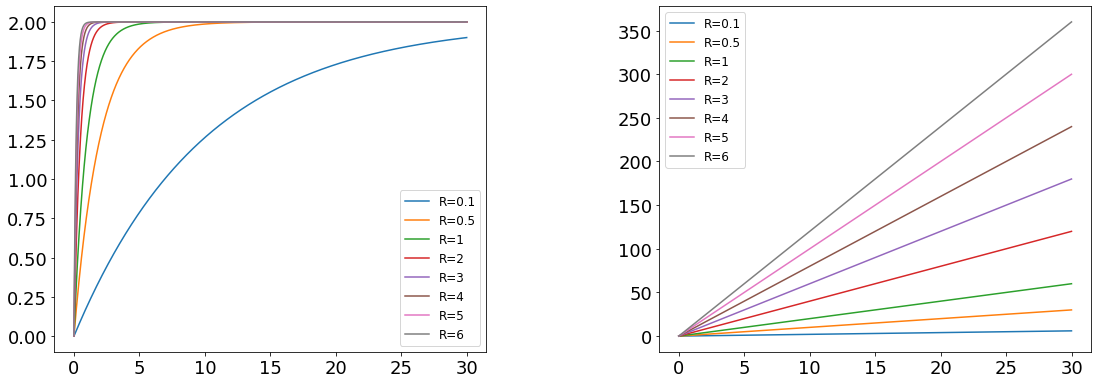

In [3]:
## Define step size functions
def var_stepsize1(x,dtmin, dtmax,R):
    return (dtmax-dtmin)*(np.abs(x))*R+dtmin

def var_stepsize2(x,dtmin, dtmax, R):
    return (dtmax-dtmin)*(1-np.exp(-np.abs(x)*R))+dtmin


# Plot the fimction of the 
fig, (ax1,ax2)= plt.subplots(1, 2,figsize=(18,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9, top=0.9, wspace=0.4, hspace=0.4)

x=np.arange(0.0001,30,0.01)
Rrange=[0.1,0.5,1,2,3,4,5,6] # different values of the parameter R 
for ri in Rrange:
    ax1.plot(x,var_stepsize2(x,0.0001, 2, ri),label="R="+str(ri))
    ax2.plot(x,var_stepsize1(x,0.0001, 2,ri),label="R="+str(ri))
ax1.legend()
ax2.legend()

Ultimately we would like to use the geometry of the problem, such as using the absolute value of $ f(x) =\|-\nabla V(x)\| = \| -\frac{1}{x^3}+2x\|$. 
The idea is to use 
$$ g(x) = \frac{1}{f(x)} \\ 
 g(x) = \frac{1}{\|-\nabla V(x)\|} \\ 

g(x) = \frac{1}{ \|-\frac{1}{x^3}+2x\| }$$
and 
$$ g'(x) =\frac{- \|\frac{3}{x^4}+2\|}{\|-\frac{1}{x^3}+2x\|^2} $$


The issue is that we would also like to have some control regarding the minimum and maximum value taken by the time steps. Therefore, we can create a new function which bounds the value of $\|-\nabla V(x)\|$ such that the modified time $g(x)\Delta s$ stays bounded between $\Delta t_{min}=0.001$ and $\Delta t_{max}=0.1$. We follow the steps in Huang&Leimkuhler and set $m=\frac{\Delta t_{min}}{\Delta s}$ and $M= \frac{\Delta t_{max}}{\Delta s}$ and set the function: $f(x)= \|-\nabla V(x)\|$ becomes: 
$$
\tilde{f} = \frac{\|f(x)\| + m}{\frac{1}{M}(\|f(x)\|+m)+1}
$$
such that : 

$$
g(x) = \frac{1}{\tilde{f}} = \frac{\frac{1}{M}(\|f(x)\|+m)+1}{\|f(x)\| + m}.
$$
and we have that: 

$$
g'(x) = \frac{1}{\tilde{f}} = \frac{-\|f(x)\|'}{(\|f(x)\| + m)^2}.
$$


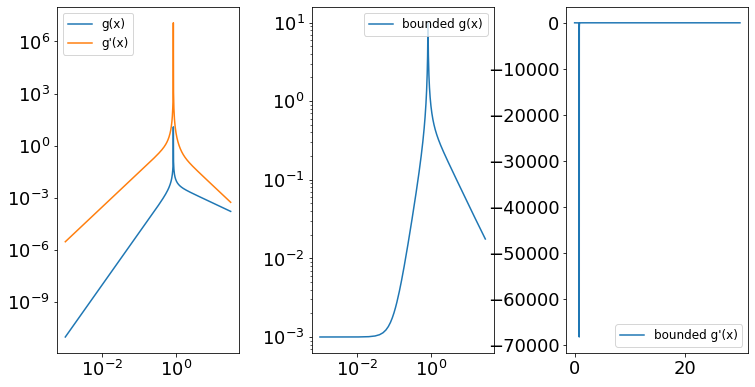

In [4]:
def g(x):
    """
    Compute the value of the adaptive function choosen:
    x: float 
    """
    x3=np.power(x,3)
    nablaV=np.abs(-1/x3+2*x)
    laplacienV=np.abs(3/(x3*x)+2)
    gx = 1/nablaV
    gprime=laplacienV*np.power(gx,2)
    re=np.array([gx,gprime])
    return re

def g_bounded(x,h,dtmin,dtmax):
    """
    Compute the value of the adaptive function choosen:
    x: float 
    """
    M=h/dtmin
    m=h/dtmax
    x3=np.power(x,3)

    # value of function f
    f=np.abs(-1/x3+2*x)
    fprime=np.abs(3/(x3*x)+2)

    #compute gx
    gx_num=1/M*(f+m)+1
    gx_den =f+m 
    gx=gx_num/gx_den

    #compute gx prime 
    gxprime=-fprime/(gx_den*gx_den)

    #return
    re=np.array([gx,gxprime])
    return re

fig, (ax1,ax2,ax3)= plt.subplots(1, 3,figsize=(12,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9, top=0.9, wspace=0.4, hspace=0.4)
h=0.01
dtmax=0.1
dtmin=10**(-5)
x=np.arange(0.001,30,0.01)
ax1.loglog(x,h*g(x)[0,::],label="g(x)")
ax1.loglog(x,g(x)[1,::],label="g'(x)")
ax2.loglog(x,g_bounded(x,h,dtmin,dtmax)[0,::],label="bounded g(x)")
ax3.plot(x,g_bounded(x,0.001,10**(-5),0.1)[1,::],label="bounded g'(x)")
ax1.legend()
ax2.legend()
ax3.legend()




However, we would like to try with a smooth function hoping to obtain better results: 

$$
g(x) = \frac{M\sqrt{f^2(x)+m^2}}{\sqrt{f^2(x)+m^2}+1}
$$
and we have 
$$
g'(x) = \frac{M^2 f(x) f'(x)}{ \sqrt{f^2(x)+m^2} \left(\sqrt{f^2(x) + m^2}+M \right)^2}
$$


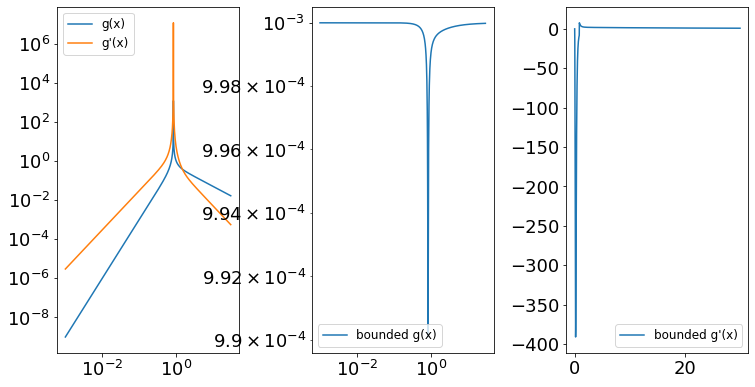

In [5]:


def g4(x,h,dtmin,dtmax):
    """
    Compute the value of the adaptive function choosen:
    x: float 
    """
    M=h/dtmin
    m=h/dtmax
    x3=np.power(x,3)

    # value of function f
    f=(-1/x3+2*x)
    fprime=(3/(x3*x)+2)

    #compute gx
    gx_num=np.sqrt(f*f+m*m)
    gx_den = M*gx_num+1
    gx=gx_num/gx_den

    #compute gx prime 
    gxp_den=gx_num+M
    gxprime= M*M*f*fprime/(gx_num*gxp_den*gxp_den)

    #return
    re=np.array([gx,gxprime])
    return re


fig, (ax1,ax2,ax3)= plt.subplots(1, 3,figsize=(12,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9, top=0.9, wspace=0.4, hspace=0.4)
h=0.01
dtmax=0.1
dtmin=10**(-5)
x=np.arange(0.001,30,0.01)
ax1.loglog(x,g(x)[0,::],label="g(x)")
ax1.loglog(x,g(x)[1,::],label="g'(x)")
ax2.loglog(x,g4(x,h,dtmin,dtmax)[0,::],label="bounded g(x)")
ax3.plot(x,g4(x,0.001,10**(-5),0.1)[1,::],label="bounded g'(x)")
ax1.legend()
ax2.legend()
ax3.legend()



We set up 3 files with the three different functions we discussed above; 
1. "infinitedoublewell_adaptive_gx1" uses $g(x)= (\Delta t_{\text{max}}-\Delta t_{\text{min}}) \left(1-\exp(- x R) \right)+ \Delta t_{\text{min}}$
2. "infinitedoublewell_adaptive_gx2" uses $g(x)= (\Delta t_{\text{max}}-\Delta t_{\text{min}}) R x+ \Delta t_{\text{min}}$
3. "infinitedoublewell_adaptive_gx3" uses $g(x) =  \frac{\frac{1}{M}(\|f(x)\|+m)+1}{\|f(x)\| + m}.$.
4. "infinitedoublewell_adaptive_gx4" uses $g(x) = \frac{M\sqrt{f^2(x)+m^2}}{\sqrt{f^2(x)+m^2}+1}$
$.

In [9]:

%run "/home/s2133976/OneDrive/ExtendedProject/codingUsingNumba/WeakSDEapproximation/numba code/infinitedoublewell_adaptivegx1.py"
%run "/home/s2133976/OneDrive/ExtendedProject/codingUsingNumba/WeakSDEapproximation/numba code/infinitedoublewell_adaptivegx2.py"
%run "/home/s2133976/OneDrive/ExtendedProject/codingUsingNumba/WeakSDEapproximation/numba code/infinitedoublewell_adaptivegx3.py"
%run "/home/s2133976/OneDrive/ExtendedProject/codingUsingNumba/WeakSDEapproximation/numba code/infinitedoublewell_adaptivegx4.py"

%run "/home/s2133976/OneDrive/ExtendedProject/codingUsingNumba/WeakSDEapproximation/numba code/infinitedoublewell_nsample.py"


In [7]:
def plot_dist(y,tau,dt,n_samples,T,title,ax):
    ax.set_title(str(title)+", $\\tau$="+str(tau)+", h="+str(dt)+", \n N="+str(n_samples)+", T="+str(T))

    #Plot 1
    histogram,bins = np.histogram(y,bins=100,range=[-5,10], density=True)

    midx = (bins[0:-1]+bins[1:])/2
    histogram=(histogram/np.sum(histogram))
    ax.plot(midx,histogram,label='q-Experiment')


    ### true distribution 
    # rho = np.exp(- U(midx)/tau)
    # rho = rho / ( np.sum(rho)* (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
    # ax1.plot(midx,rho,'--',label='Truth')

    rho = np.exp(- (U(midx)/tau))
    rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) 
    rho=(rho/np.sum(rho))*2
    rho=[rho[i] if i>50 else 0 for i in range(len(rho))]
    ax.plot(midx,rho,'--',label='Truth') 
    ax.legend()

Fistlty we need to make a quick visual check to make sure that each adaptive method seems to be converging towards the actual method of interest. 

In [10]:
%time ytest= IDW_nsample_ada1(10,1,0.1,0.1) # compile the function
%time ytest= IDW_nsample_ada2(10,1,0.1,0.1)  # compile the function
%time ytest= IDW_nsample_ada3(10,1,0.1,0.1) # compile the function
%time ytest= IDW_nsample_ada4(10,1,0.1,0.1)  # compile the function

CPU times: user 347 ms, sys: 1.46 ms, total: 348 ms
Wall time: 343 ms
CPU times: user 486 ms, sys: 1.37 ms, total: 487 ms
Wall time: 331 ms
CPU times: user 482 ms, sys: 2.18 ms, total: 484 ms
Wall time: 343 ms
CPU times: user 507 ms, sys: 0 ns, total: 507 ms
Wall time: 366 ms


In [11]:
n_samples=10**4
T=10
dt=0.01
tau=0.15
# run non adaptive stepsize
y_nonada= IDW_nsample(n_samples,T,dt,tau) 
y_adag1= IDW_nsample_ada1(n_samples,T,dt,tau) 
y_adag2= IDW_nsample_ada2(n_samples,T,dt,tau) 
y_adag3= IDW_nsample_ada3(n_samples,T,dt,tau) 
y_adag4= IDW_nsample_ada3(n_samples,T,dt,tau) 

In [12]:
#%time ytest=y_compile = DW_sde_fast(1000,3,10,0.01,20) # compile the function
def plot_dist(y,tau,dt,n_samples,T,title,ax):
    ax.set_title(str(title)+", $\\tau$="+str(tau)+", h="+str(dt)+", \n N="+str(n_samples)+", T="+str(T))

    #Plot 1
    histogram,bins = np.histogram(y,bins=100,range=[-5,5], density=True)

    midx = (bins[0:-1]+bins[1:])/2
    histogram=(histogram/np.sum(histogram))
    ax.plot(midx,histogram,label='q-Experiment')

    rho = np.exp(- (U(midx)/tau))
    rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) 
    rho=(rho/np.sum(rho))*2
    rho=[rho[i] if i>50 else 0 for i in range(len(rho))]
    ax.plot(midx,rho,'--',label='Truth') 
    ax.legend()

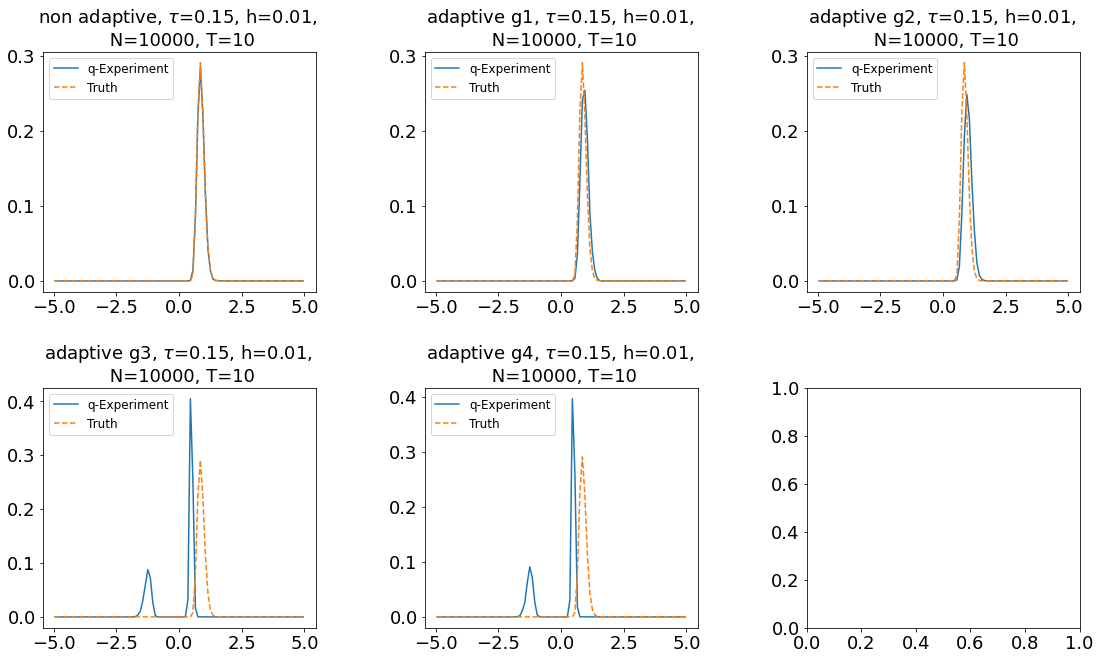

In [17]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6))= plt.subplots(2,3,figsize=(18,10))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plot_dist(y_nonada,tau,dt,n_samples,T,"non adaptive",ax1)
plot_dist(y_adag1,tau,dt,n_samples,T,"adaptive g1",ax2)
plot_dist(y_adag2,tau,dt,n_samples,T,"adaptive g2",ax3)
plot_dist(y_adag3,tau,dt,n_samples,T,"adaptive g3",ax4)
plot_dist(y_adag4,tau,dt,n_samples,T,"adaptive g4",ax5)


Looking at the distribution, it seems that the distribution of G3 is the only one which is further from the invariant distribution. In addition, it seems to be quiet unstable. 
# Ignore from there 
## Compute escaping trajectories and compare against non adaptive

To do so we design the function below that computes the number of escaping trajectory for a particular method used. 

In [147]:
def nesc_eta_dtlist(n_samples,dt_var,tau,T,b,method):
    """
    Function to establish the proportion of escaping trajectories
    Input :
    ------
    n_samples: int
        number of samples generated
    dt: float
        Time increment
    list_var: list of float
        list of values of the temperature to evaluate 
    T: int
        Final time until the solution is ran
    b: int
        Boundary selected
    """
    # empty vector to save results
    y_res = np.zeros((len(dt_var),n_samples))
    #list of escaping trajectories
    nesc_list=[]
    #run through the different values of tau 
    for i in range(len(dt_var)):
        dt_i=dt_var[i]
        y_exact = method(n_samples,T,dt_i,tau)
        y_res[i,::]=y_exact

        #compute the proportion of escaping trajectory
        res = len(y_exact[y_exact<0])+len(y_exact[y_exact>b])
        res = res/len(y_exact)
        nesc_list.append(res)
        
    return(nesc_list,y_res)

In [190]:
# set parameter
n_samples=10**5
tau=0.15
T=100

#set list of time increment
b1=0.05
b2=0.4
inc=(b2-b1)/10
dtlist3=np.arange(b1,b2+inc,inc)
#set up bound 
b=10

#compute the number of escaping trajectory
nesc_nonada, y_nonada = nesc_eta_dtlist(n_samples,dtlist3,tau,T,b,IDW_nsample)


In [191]:
nesc_ada1, y_ada1 = nesc_eta_dtlist(n_samples,dtlist3,tau,T,b,IDW_nsample_ada1)


In [192]:
nesc_ada2, y_ada2 = nesc_eta_dtlist(n_samples,dtlist3,tau,T,b,IDW_nsample_ada2)


In [193]:
nesc_ada3, y_ada3 = nesc_eta_dtlist(n_samples,dtlist3,tau,T,b,IDW_nsample_ada3)

Text(0.5, 1.0, '$T=100$, $n_{samples}=10^5$')

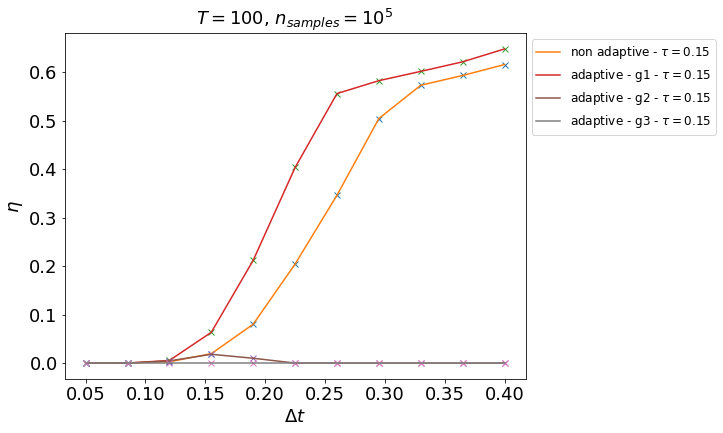

In [194]:
fig, (ax)= plt.subplots(1, 1,figsize=(8,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

ax.plot(dtlist3,nesc_nonada,"x") #plot non adaptive
ax.plot(dtlist3,nesc_nonada,label="non adaptive - $\\tau=0.15$")

ax.plot(dtlist3,nesc_ada1,"x") #plot  adaptive
ax.plot(dtlist3,nesc_ada1,label="adaptive - g1 - $\\tau=0.15$")

ax.plot(dtlist3,nesc_ada2,"x")
ax.plot(dtlist3,nesc_ada2,label="adaptive - g2 - $\\tau=0.15$")

ax.plot(dtlist3,nesc_ada3,"x")
ax.plot(dtlist3,nesc_ada3,label="adaptive - g3 - $\\tau=0.15$")

ax.legend(loc='upper left', bbox_to_anchor=(1, 1)) #add the legend
ax.set_ylabel("$\eta $")
ax.set_xlabel("$\Delta t $")
ax.set_title("$T=100$, $n_{samples}=10^5$")

### Plot distribution to make sure we get similar results 
    

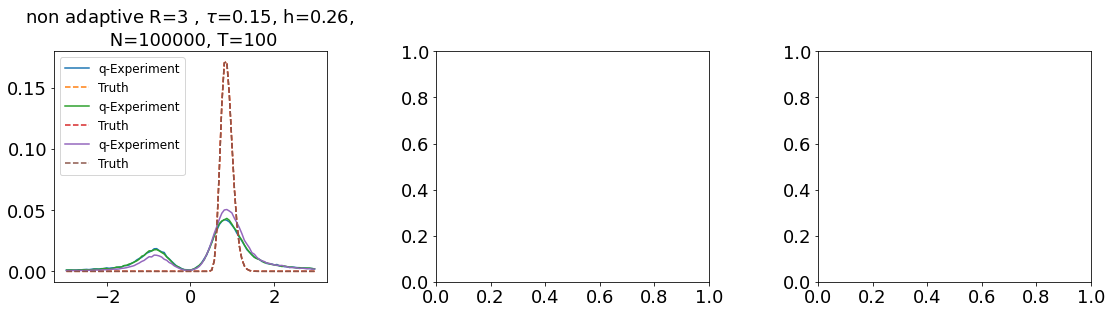

In [51]:
fig, (ax1,ax2,ax3)= plt.subplots(1,3,figsize=(18,4))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
i=6
tau=0.15
dt=dtlist3[i]
plot_dist(y_res3[i,::],0.15,dt,n_samples,T,"non adaptive ",ax1)
plot_dist(y_res4[i,::],tau,dt,n_samples,T,"adaptive R=6 ",ax1)
plot_dist(y_res5[i,::],tau,dt,n_samples,T,"non adaptive R=3 ",ax1)